This program is about using gradient descent and scipy to do logistic regression.

The iris dataset obtained from https://gist.github.com/netj/8836201.

In [122]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from functools import partial
from plotting_utils import plotter_classifier

# Glimpse at Dataset

In [123]:
iris = pd.read_csv('iris.csv')
iris.iloc[:6,:]

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
5,5.4,3.9,1.7,0.4,Setosa


There are 150 observations in the dataset. Each observation has 4 continuous features corresponding to 3 possible categories of iris flower which are 'Sentosa', 'Versicolor', and 'Virginica'. Becasue there are more than 2 categories, using the Softmax function will be proper.

Softmax equation:
$$
p(t_{nk} = 1 \vert x_n, w) = \frac{e^{w_k^{T} \cdot \phi(x_n)}}{\sum\limits^{K}_{l = 1}e^{w_l^{T}\phi(x_n)}}
$$

$$
\begin{align*}
Where~&n = n^{th} observation \\
      &k = k^{th} class \\
      &\phi = basis~function \\
      &x_n = features~of~n^{th}~observation \\
      &w = weight~matrix~which~each~row~records~the~weight~for~each~class \\
\end{align*}
$$

## Softmax

The function calculates the probability of oberservation n belongs to class k. $p(t=1 \vert x_n, w)$ will be a matrix with n rows and k columns where the sum of each row is always 1. Our prediction will be the class with highest probability.

The weights of each class could be how much that class favors each feature. Each class scores the feature by $e^{\phi(x)}$. In the denominator, it calculates the total score rate by all classes. Score of one class divided by total score of classes gives probability.  The reason of using exponential: Firstly, the value cannot be negative, or it will give negative probabilities. Secondly, y = $e^X$ grows exponentially. Each unit increase in x generates higher amount of increase in y than y = x. By this characteristic, the correct class will be more seperable from others.

## Softmax to negative log likelihood

$$
\begin{align*}
posterior &= \frac{prior \cdot likelihood}{evidence} \\
-log(posterior) & = -log(prior) - log(likelihood)
\end{align*}
$$
Evidence ignored since it does not depend on w, it's derivative will be 0.

Choose a Gaussian prior for the weights, which is equivalent to adding a L2 regularization.
$$
prior = p(w) = N(w \vert 0, \alpha^{-1}I) \propto e^{\frac{\alpha}{2}w^{T}w}~~~~~~~~~~~
log(p(w)) = -\frac{\alpha}{2}w^Tw
$$
Use softmax as the likelihood funciton we get:
$$
f(w) = \frac{\alpha}{2}w^Tw - \sum\limits_{n = 1}^{N}[\sum\limits_{k = 1}^{K}t_{nk}w_k^{T}\phi(x_n)-log(\sum\limits_{l=1}^{K}e^{w_l^K\phi(x_n)})]
$$

In [124]:
def neg_log_like(w, x, t, alpha):

	first_term = (alpha / 2) * np.sum(np.square(w))

	w = np.reshape(w, (t.shape[1], x.shape[1]))
	t_hat = np.matmul(x, w.T)
	
	in_log = np.sum(np.exp(t_hat), axis = 1)
	second_term = np.sum(t * t_hat, axis = 1) - np.log(in_log)
	second_term = np.sum(second_term)
	
	result = np.sum(first_term) - second_term
	
	return result

## Calculate $\frac{\partial f(w)}{\partial w_{km}}$ to do gradient descent

$$
\frac{\alpha}{2}w^Tw = \frac{\alpha}{2}(w_{11}^2 + w_{12}^2 ...)
$$
For first term, the weights other than $w_{km}$ can be cancelled.


For the second term, we need the $\phi(x_n)$ associate with $w_{km}$. $t_{nk}$ should be remained since it might be 0. In the last part, since there's a log, the whole row associated with $w_{km}$ should be contained, then $\phi$ associated should be pulled out because of chain rule.

$$
\begin{aligned}
\frac{\partial f(w)}{\partial w_{km}} &= \alpha w_{km} - \sum\limits_{n=1}^{N}[t_{nk}\phi_{m}(x_{n}) - \frac{\phi_{m}(x_{n})e^{w_{k}^{T}\phi(x_{n})}}{\sum\limits_{l=1}^{K}e^{w_{l}^{T}\phi(x_{n})}}]
                                                
\end{aligned}
$$

In [125]:
def grad_neg_log_like(w, x, t, alpha):

	w = np.reshape(w, (t.shape[1], x.shape[1]))
	
	alpha_w = alpha * w

	tT_x = np.matmul(t.T, x)

	t_hat = np.matmul(x, w.T)
	exp_t_hat = np.exp(t_hat)
	grad_w = np.zeros((w.shape[0], w.shape[1]))

	lower = np.sum(np.exp(t_hat), axis = 1)

	for k in range(w.shape[0]):

		for m in range(w.shape[1]):


			const = tT_x[k,m]

			upper = x[:, m] * exp_t_hat[:,k]
			
			grad_w[k,m] = alpha_w[k,m] - (const - np.sum(upper / lower))
			grad_w[k,m] = alpha_w[k,m] - (const - np.sum(upper/lower))
			
	result = -1 * (alpha * w - grad_w)
	result = np.reshape(result, (1, result.shape[0] * result.shape[1]))
	
	return result

## Split the data into train set and test set

In [126]:
X = iris.iloc[:, :-1].to_numpy()
Y = iris.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33)

## Since we will visualize the data, reduce the dimension to 2

Firstly, normalized each column in trainset be their mean and sigma. The same means and sigmas will be use to normalize test set.

In [127]:
col_mean = x_train.mean(axis = 0)
col_sigma = np.sqrt(x_train.var(axis = 0))

normalized_x_train = (x_train - col_mean) / col_sigma

Then do the dimensionality reduciton with PCA.

In [128]:
reduced_x_train = PCA(n_components = 2).fit_transform(normalized_x_train)
reduced_x_train.shape

(100, 2)

This is how the distribution of the classes look.

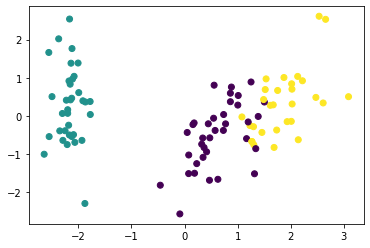

In [129]:
plt.scatter(x = reduced_x_train[:,0], y = reduced_x_train[:,1], c = y_train.factorize()[0])

# Basis functions

There are 3 candidate basis functions.

1. Linear: Insert 1 into all feature vectors.
2. Quadratic: Insert the squares of original features vector to the linear basis function.
3. General: Insert the interactions of original features vectors to the quadratic basis function.

In [130]:
def phi_linear(x):

    return np.insert(x, 0, 1, axis = 1)

def phi_quadratic(x):

    return np.concatenate((phi_linear(x), np.square(x)), axis = 1)

def phi_general(x):

    combinations = phi_quadratic(x)

    for i in range(0, (x.shape[1] - 1)):

        tail = x[:, i + 1:]

        for j in range(tail.shape[1]):

            new_column = x[:, i] * tail[:, j]

            new_column = np.reshape(new_column, (x.shape[0] ,1))

            combinations = np.concatenate((combinations, new_column), axis = 1)

    return combinations

In [131]:
feed_y_train = pd.get_dummies(y_train).to_numpy()
feed_y_train[:5,:]

array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

# Optimize with scipy

## Using Linear basis

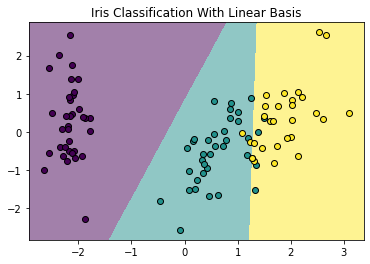

In [132]:

alpha = 1e-6

w = np.zeros((feed_y_train.shape[1], phi_linear(reduced_x_train).shape[1]))

loss_func = partial(neg_log_like, x = phi_linear(reduced_x_train), t = feed_y_train, alpha = alpha)
grad_func = partial(grad_neg_log_like, x = phi_linear(reduced_x_train), t = feed_y_train, alpha = alpha)

options = dict()
options["maxiter"] = 20000
options["ftol"] = 1e-7
results = scipy.optimize.minimize(fun = loss_func, x0 = w, jac = grad_func, method = "L-BFGS-B", options = options)
assert(results.success)
w_hat_linear = results.x
w_hat_linear = np.reshape(w_hat_linear, (feed_y_train.shape[1], phi_linear(reduced_x_train).shape[1]))

plotter_classifier(w_hat_linear.T, phi_linear, reduced_x_train, np.argmax(feed_y_train, axis = 1), title="Iris Classification With Linear Basis")
plt.show()

## Using quadratic basis

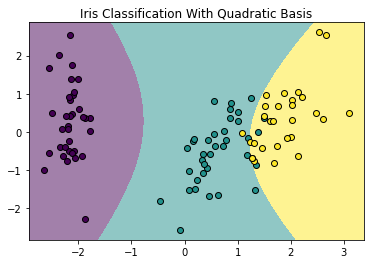

In [133]:
w = np.zeros((feed_y_train.shape[1], phi_quadratic(reduced_x_train).shape[1]))

loss_func = partial(neg_log_like, x = phi_quadratic(reduced_x_train), t = feed_y_train, alpha = alpha)
grad_func = partial(grad_neg_log_like, x = phi_quadratic(reduced_x_train), t = feed_y_train, alpha = alpha)

options = dict()
options["maxiter"] = 20000
options["ftol"] = 1e-7
results = scipy.optimize.minimize(fun = loss_func, x0 = w, jac = grad_func, method = "L-BFGS-B", options = options)
assert(results.success)
w_hat_quadratic = results.x
w_hat_quadratic = np.reshape(w_hat_quadratic, (feed_y_train.shape[1], phi_quadratic(reduced_x_train).shape[1]))

plotter_classifier(w_hat_quadratic.T, phi_quadratic, reduced_x_train, np.argmax(feed_y_train, axis = 1), title="Iris Classification With Quadratic Basis")
plt.show()

## Using general basis

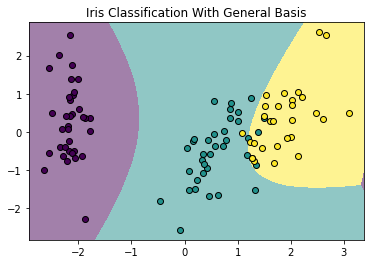

In [134]:
w = np.zeros((feed_y_train.shape[1], phi_general(reduced_x_train).shape[1]))

loss_func = partial(neg_log_like, x = phi_general(reduced_x_train), t = feed_y_train, alpha = alpha)
grad_func = partial(grad_neg_log_like, x = phi_general(reduced_x_train), t = feed_y_train, alpha = alpha)

options = dict()
options["maxiter"] = 20000
options["ftol"] = 1e-7
results = scipy.optimize.minimize(fun = loss_func, x0 = w, jac = grad_func, method = "L-BFGS-B", options = options)
assert(results.success)
w_hat_general = results.x
w_hat_general = np.reshape(w_hat_general, (feed_y_train.shape[1], phi_general(reduced_x_train).shape[1]))

plotter_classifier(w_hat_general.T, phi_general, reduced_x_train, np.argmax(feed_y_train, axis = 1), title="Iris Classification With General Basis")
plt.show()

We can see that with different basis functions, the classifier is able to create different decision boundaries. For linear basis function, the boundaries are all straight. As the quadratic and general basis function is used, the decision boundary start to get more curves. In practice, the reasonable features could be identified during EDA.

# Test on test set

Do the same thing. Normalize then dimensinality reduction.

Note: becasue in reality we don't have the observation for whole population, we should normalize the test set with means and standard deviations of the training set.

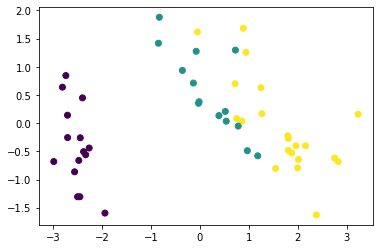

In [135]:
normalized_x_test = (x_test - col_mean) / col_sigma
reduced_x_test = PCA(n_components = 2).fit_transform(normalized_x_test)

y_test = np.argmax(pd.get_dummies(y_test).to_numpy(), axis = 1)
plt.scatter(reduced_x_test[:,0], reduced_x_test[:,1], c = y_test)

In [136]:
linear_pred = np.argmax(np.matmul(phi_linear(reduced_x_test), w_hat_linear.T), axis = 1) == y_test
print('The accuracy of using linear basis is: ' + str(linear_pred.sum() / len(linear_pred)))

quadratic_pred = np.argmax(np.matmul(phi_quadratic(reduced_x_test), w_hat_quadratic.T), axis = 1) == y_test
print('The accuracy of using quadratic basis is: ' + str(quadratic_pred.sum() / len(quadratic_pred)))

general_pred = np.argmax(np.matmul(phi_general(reduced_x_test), w_hat_general.T), axis = 1) == y_test
print('The accuracy of using general basis is: ' + str(general_pred.sum() / len(general_pred)))

The accuracy of using linear basis is: 0.74
The accuracy of using quadratic basis is: 0.86
The accuracy of using general basis is: 0.84
